> ![](https://raw.githubusercontent.com/SunnySuite/Sunny.jl/main/assets/sunny_logo.jpg)
_This is a [tutorial](https://github.com/SunnySuite/SunnyTutorials/tree/main/tutorials)
 for the [Sunny](https://github.com/SunnySuite/Sunny.jl/) package,
 which enables dynamical simulations of ordered and thermally disordered spins with dipole
 and higher order moments._

## Welcome to a Sunny Tutorial on the Diamond Lattice System CoRh<sub>2</sub>O<sub>4</sub>
**Script**: Diamond Lattice Finite Temperature Calculation <br>
**Inspired by**: CoRh<sub>2</sub>O<sub>4</sub> Powder
(Ge _et al._ https://doi.org/10.1103/PhysRevB.96.064413) <br>
**Authors**: Martin Mourigal, David Dahlbom <br>
**Date**: September 11, 2023  (Sunny 0.5.4) <br>
**Goal**: This script is to calculate the temperature dependence of the magnon excitations in the
spin-3/2 Heisenberg Diamond Antiferromagnet and compare to powder-averaged results obtained for
the compound CoRh<sub>2</sub>O<sub>4</sub> <br>

---
#### Loading Packages

In [1]:
using Sunny, GLMakie, ProgressMeter, Statistics
Sunny.offline_viewers()

┌ Warning: This function is deprecated and does nothing.
└ @ Sunny ~/.julia/packages/Sunny/rI8Hd/src/Sunny.jl:138


#### Defining Custom Functions For This Script

The function `quench!` randomizes the spins of a given `System`, fixes a
target temperature, and lets the system relax at this temperature for `nrelax`
integration steps.

In [2]:
function quench!(sys, integrator; kTtarget, nrelax)
    randomize_spins!(sys);
    integrator.kT = kTtarget;
    prog          = Progress(nrelax; dt=10.0, desc="Quenched and now relaxing: ", color=:green);
    for _ in 1:nrelax
        step!(sys, integrator)
        next!(prog)
    end
end

quench! (generic function with 1 method)

`anneal!` takes a temperature schedule and cools the `System` through it,
with `ndwell` steps of the integrator at each temperature in the schedule.
Returns the energy at the end of the dwell for each scheduled temperature.

In [3]:
function anneal!(sys,  integrator;  kTschedule, ndwell)
    nspins = prod(size(sys.dipoles));
    ensys  = zeros(length(kTschedule))
    prog   = Progress(ndwell*length(kTschedule); dt=10.0, desc="Annealing: ", color=:red);
    for (i, kT) in enumerate(kTschedule)
        integrator.kT = kT
        for _ in 1:ndwell
            step!(sys, integrator)
            next!(prog)
        end
        ensys[i] = energy(sys)
    end
    return ensys/nspins
end

anneal! (generic function with 1 method)

`dwell!` takes a `System`, sets a target temperature, and has the system
dwell at this temperature for `ndwell` integration steps.

In [4]:
function dwell!(sys, integrator; kTtarget, ndwell)
    integrator.kT = kTtarget;
    prog          = Progress(ndwell; dt=10.0, desc="Dwelling: ", color=:green);
    for _ in 1:ndwell
        step!(sys, integrator)
        next!(prog)
    end
end

dwell! (generic function with 1 method)

`sample_sf!` samples a structure factor, which may be either an instant or
dynamical structure factor. The integrator is run `ndecorr` times before each
one of the samples is taken.

In [5]:
function sample_sf!(sf, sys, integrator; nsamples, ndecorr)
    prog  = Progress(nsamples*ndecorr; dt=10.0, desc="Sampling SF: ", color=:red);
    for _ in 1:nsamples
        for _ in 1:ndecorr
            step!(sys, integrator)
            next!(prog)
        end
        add_sample!(sf, sys)    # Accumulate the newly sampled structure factor into `sf`
    end
end

sample_sf! (generic function with 1 method)

`powder_average` powder averages a structure factor. Works for both instant
and dynamical structure factors. To prevent smearing, removes Bragg peaks
before introducing energy broadening. Bragg peaks are added back at ω=0 after
broadening.

In [6]:
function powder_average(sc, rs, npts, formula; η=0.1)
    prog   = Progress(length(rs); dt=10., desc="Powder Averaging: ", color=:blue)
    ωs     = available_energies(sc)
    output = zeros(Float64, length(rs), length(ωs))
    for (i, r) in enumerate(rs)
        qs = reciprocal_space_shell(sc.crystal, r, npts)
        vals = intensities_interpolated(sc, qs, formula)
        bragg_idxs = findall(x -> x > maximum(vals)*0.9, vals)
        bragg_vals = vals[bragg_idxs]
        vals[bragg_idxs] .= 0
        vals = broaden_energy(sc, vals, (ω,ω₀)->lorentzian(ω-ω₀, η))
        vals[bragg_idxs] .= bragg_vals
        output[i,:] .= mean(vals, dims=1)[1,:]
        next!(prog)
    end
    return output
end

powder_average (generic function with 1 method)

---
### System Definition for CoRh<sub>2</sub>O<sub>4</sub>

Define the crystal structure of CoRh$_2$O$_4$  in the conventional cell
from Bertaut 1959 crystal structure

In [7]:
lat_vecs    = lattice_vectors(8.495, 8.495, 8.495, 90, 90, 90)
basis_vecs  = [[0.0000, 0.0000, 0.0000]];
basis_types = ["Co"];
spgr        = 227;
magxtal     = Crystal(lat_vecs, basis_vecs, spgr; types=basis_types, setting="1")
view_crystal(magxtal, 2.6)
print_symmetry_table(magxtal, 4.0)

Atom 1
Type 'Co', position [0, 0, 0], multiplicity 8
Allowed g-tensor: | A  0  0 |
                  | 0  A  0 |
                  | 0  0  A |
Allowed anisotropy in Stevens operators:
    c₁*(𝒪[4,0]+5𝒪[4,4]) +
    c₂*(𝒪[6,0]-21𝒪[6,4])
Allowed exchange matrix: | A  0  0 |
                         | 0  A  0 |
                         | 0  0  A |

Bond(1, 3, [0, 0, 0])
Distance 3.6784429025744, coordination 4
Connects 'Co' at [0, 0, 0] to 'Co' at [0.25, 0.25, 0.25]
Allowed exchange matrix: | A  B  B |
                         | B  A  B |
                         | B  B  A |



Assign local Hilbert space

In [8]:
S   = 3/2
lhs = [SpinInfo(1, S=S, g=2)]
formfactors = [FormFactor("Co2")];

Create `System` and randomize it

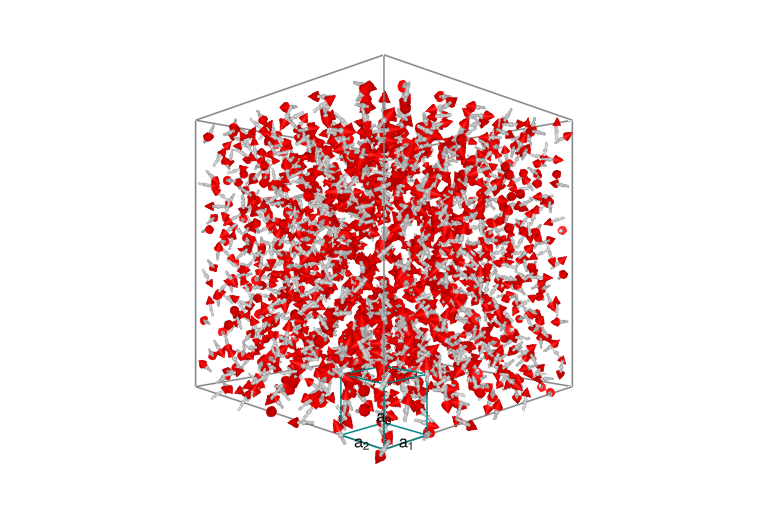

In [9]:
sunmode = :dipole
latsize = (6,6,6)
sys     = System(magxtal, latsize, lhs, sunmode; seed=1)
randomize_spins!(sys)
plot_spins(sys; ghost_radius=10.0)

Define Exchange Interactions

In [10]:
scaleJ = 0.63
valJ1  = 1.00*scaleJ
set_exchange!(sys, valJ1, Bond(1, 3, [0, 0, 0]));

---
### System thermalization to an ordered, yet finite temperature, state

Define Langevin Integrator and Initialize it

In [11]:
Δt0        = 0.025/abs(scaleJ*S); ## Time steps in Langevin
λ0         = 0.05; ## Langevin damping, usually 0.05 or 0.1 is good.
kT0        = 10.0*abs(scaleJ*S); ## Initialize at some temperature
integrator = Langevin(Δt0; λ=λ0, kT=kT0);

Thermalization
Option 1: Quench the system from infinite temperature to a target temperature.
Note: this may lead to a poorly thermalized sample

In [12]:
# quench!(sys, integrator; kTtarget=kT0, nrelax=10000);

Option 2: Anneal (according to a temperature schedule) than dwell once reach base
Note: starting from very high temperature here

In [13]:
kTs = [abs(scaleJ*S)*10 * 0.9^k for k in 0:100]
anneal!(sys,integrator;kTschedule=kTs,ndwell=10)
dwell!(sys,integrator;kTtarget=kTs[end],ndwell=20)

Option 3: Apply an additional gradient-descent minimization

In [14]:
minimize_energy!(sys,maxiters=100)

60

Plot the resulting spin system to check ordering in real space

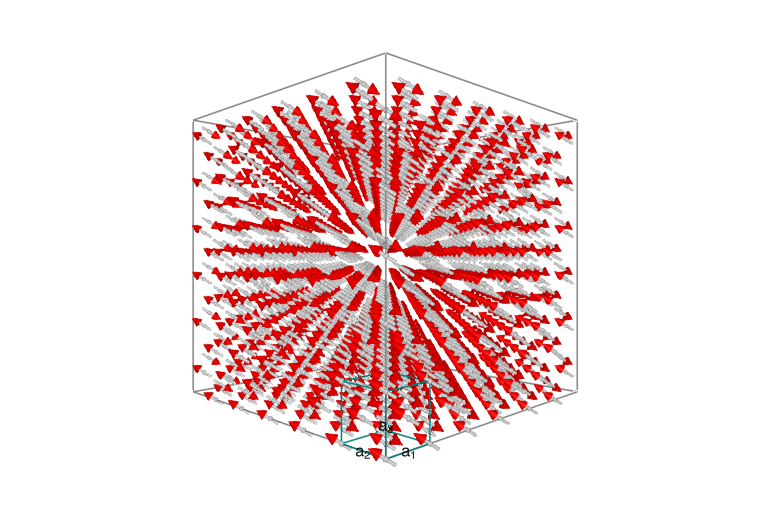

In [15]:
plot_spins(sys)

---
### Calculation of Neutron Scattering Responses

#### Dynamical and energy-integrated two-point correlation functions

Calculate the Time Traces and Fourier Transform: Dynamical Structure Factor (first sample)

In [16]:
ωmax     = 6.0  # Maximum  energy to resolve
nω       = 100  # Number of energies to resolve
sc       = dynamical_correlations(sys; Δt=Δt0, nω=nω, ωmax=ωmax, process_trajectory=:symmetrize)
@time add_sample!(sc, sys) # Add a sample trajectory

  1.959477 seconds (3.10 M allocations: 62.987 MiB)


If desired, add additional decorrelated samples.

In [17]:
nsamples      = 10
ndecorr       = 100
@time sample_sf!(sc, sys, integrator; nsamples=nsamples, ndecorr=ndecorr);

Sampling SF: 100%|██████████████████████████████████████| Time: 0:00:33
 37.351076 seconds (30.97 M allocations: 631.487 MiB, 0.36% gc time, 0.14% compilation time)


#### Powder-Averaging at Zero-Temperature (at T=0)

Projection into a powder-averaged neutron scattering intensity

In [18]:
formula    = intensity_formula(sc, :perp; formfactors, kT=integrator.kT)
ωs         = available_energies(sc)
Qmax       = 3.5
nQpts      = 100
Qpow       = range(0, Qmax, nQpts)
npoints    = 200
pqw        = powder_average(sc, Qpow, npoints, formula; η=0.5);

Powder Averaging: 100%|█████████████████████████████████| Time: 0:02:37


Plot resulting Ipow(Q,W)

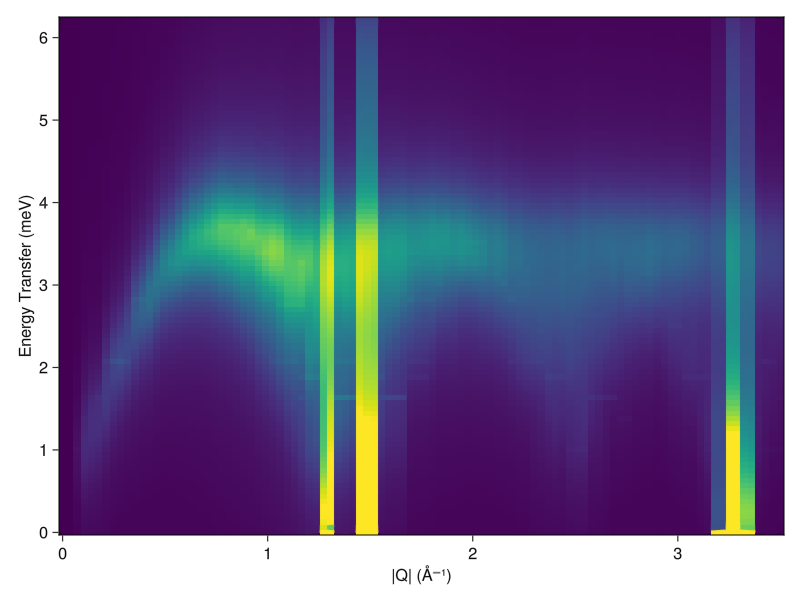

In [19]:
heatmap(Qpow, ωs, pqw;
    axis = (
        xlabel="|Q| (Å⁻¹)",
        ylabel="Energy Transfer (meV)",
        aspect = 1.4,
    ),
    colorrange = (0, 20)
)

---
### Calculation of temperature-dependent powder average spectrum

Define a temperature schedule

In [20]:
kTs        = [60 40 25 20 15 12 10 4] * Sunny.meV_per_K
pqw_res    = []
for kT in kTs
    dwell!(sys, integrator; kTtarget=kT, ndwell=1000);
    sc_loc = dynamical_correlations(sys; Δt=Δt0, nω, ωmax, process_trajectory=:symmetrize);
    add_sample!(sc_loc, sys)
    formula = intensity_formula(sc, :perp; formfactors, kT)
    push!(pqw_res, powder_average(sc_loc, Qpow, npoints, formula;  η=0.5))
end

┌ Warning: Assignment to `formula` in soft scope is ambiguous because a global variable by the same name exists: `formula` will be treated as a new local. Disambiguate by using `local formula` to suppress this warning or `global formula` to assign to the existing global variable.
└ @ ~/Dropbox (GaTech)/Group/Shared-Scripts/Github/Sunny/Tutorial_CoRh2O4_powder-finiteT_MM.ipynb:7
Powder Averaging: 100%|█████████████████████████████████| Time: 0:02:38
Powder Averaging: 100%|█████████████████████████████████| Time: 0:02:40
Powder Averaging: 100%|█████████████████████████████████| Time: 0:02:36
Powder Averaging: 100%|█████████████████████████████████| Time: 0:02:37
Powder Averaging: 100%|█████████████████████████████████| Time: 0:02:37
Powder Averaging: 100%|█████████████████████████████████| Time: 0:02:38
Powder Averaging: 100%|█████████████████████████████████| Time: 0:02:38
Powder Averaging: 100%|█████████████████████████████████| Time: 0:02:36


Plot the resulting Ipow(Q,W) as a function of temperature,
to compare with Fig.6 of https://arxiv.org/abs/1706.05881

In [1]:
fig = Figure(; resolution=(1200,600))
for i in 1:8
    r, c = fldmod1(i, 4)
    ax = Axis(fig[r, c];
        title = "kT = "*string(round(kTs[9-i], digits=3))*" (meV)",
        xlabel = r == 2 ? "|Q| (Å⁻¹)" : "",
        ylabel = c == 1 ? "Energy Transfer (meV)" : "",
        aspect = 1.4,
    )
    heatmap!(ax, Qpow, ωs, pqw_res[9-i]; colorrange = (0, 20.0))
end
fig

UndefVarError: UndefVarError: `Figure` not defined

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*